# End-to-End Machine Learning Project
### By Edd Webster

A walkthrough of using Machine Learning to do an end-to-end project.

## Introduction

This notebook goes through an example end-to-end project, whereby the scenario is that of a recently hired data scientist in a fictitious real estate company.

This notebook contains all the sample code and solutions to the exercises in chapter 2 of [Aurélien Géron](https://twitter.com/aureliengeron)'s book: Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow (2nd Edition). You can purchase a copy [here](https://www.amazon.co.uk/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=pd_lpo_sbs_14_t_0?_encoding=UTF8&psc=1&refRID=7SEEAY1W51TM14E4VAXV). You can also access Géron‘s GitHub repository [here](https://github.com/ageron/handson-ml2) and his equivalent Jupyter notebook [here](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb)

For more information about this notebook, or if you have any suggestions about how it can be improved, I'm available through all the following channels:
*    [EddWebster.com](https://www.eddwebster.com/),
*    edd.j.webster@gmail.com,
*    [@eddwebster](https://www.twitter.com/eddwebster),
*    [LinkedIn.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/),
*    [GitHub/eddwebster](https://github.com/eddwebster/),
*    [Kaggle.com/eddwebster](https://www.kaggle.com/eddwebster),
*    [HackerRank.com/eddwebster](https://www.hackerrank.com/eddwebster)

## Notebook Contents
The contents of this notebook matches that of chapter 2 of Géron's Hands-on Machine Learning book, with the Jupyter notebook setup added as an additional point at the 0 index.

This contents covers the main steps of an end-to-end project, divided as the following:
0.    [Setup](#section0)
1.    [Look at the big picture](#section1)
      +    Frame the Problem
           -    Pipelines
      +    Select a Performance Measure
           - Notations
      +    Check the Assumptions
2.    [Get the data](#section2)
      +    Download the Data
      +    Take a Quick Look at the Data Structure
      +    Create a Test Set
3.    [Discover and visualise the data to gain insights](#section3)
      +    Visualising Geographical Data
      +    Looking for Correlations
      +    Experimenting with Attribute Combinations
4.    [Prepare the data for Machine Learning algorithms](#section4)
      +    Data Cleaning
           - Scikit-Learn Design
      +    Handling Text and Categorical Attributes
      +    Custom Transformers
      +    Feature Scaling
      +    Transformation Pipelines
5.    [Select and Train a Model](#section5)
      +    Training and Evaluating on the Training Set
      +    Better Evaluation Using Cross-Validation
6.    [Fine-tune Your model](#section6)
      +    Grid Search
      +    Randomized Search
      +    Ensemble Methods
      +    Analyse the Best Models and Their Errors
      +    Evaluate Your System on the Test Set
7.    [Present your solution](#section7)
8.    [Launch, Monitor, and Maintain Your System](#section8)
*     [Summary](#sectionsummary)
*     [Exercises](#sectionex)
*     [Bibliography](#sectionbib)
*     [Appendix](#sectionappendix)

<a id='section0'></a>

## 0. Notebook Setup

In [542]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# Plotting figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Display in Jupyter
from IPython.display import Image
from IPython.core.display import HTML 

# Ignore warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

<a id='section1'></a>

## 1. Look at the big picture

### Task briefing

The task is to that of a Data Scientist of a real estate company, Machine Learning Housing Corp., to predict median house values in Californian districts, given a number of features, including: population, median income, median housing price, and so on for each block group in California.

Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). This notebook will just call them “districts” for short.

The model in this notebook will learn from this data and to predict the median housing price in any district, given all the other metrics.

### Frame the Problem

What exactly is the business objective? Building a model is probably not the end goal. How does the company expect to use and benefit from this model?
It is important to ask this questions before starting to build the model because it will determine how we frame problem, algorithms you will select, what performance measure you will use to evaluate your model, and how much effort you should spend tweaking it.

In this scenario, this model’s output (a prediction of a district’s median housing price) will be fed to another Machine Learning system (see the figure below to see the position of this Machine Learning component in the full pipeline), along with many other signals (signals are pieces of information fed to a Machine Learning system). This downstream system will determine whether it is worth investing in a given area or not. Getting this right is critical, as it directly affects revenue.

In [543]:
Image(url= "images/end_to_end_project/ml_pipeline.png", width=650)

The next question to ask before creating a Machine Learning solution is:  what the current solution looks like (if any)? This will often provide some sort of reference point for the current performance, as well as insights on how to solve the problem. In the scenario of working for MLHC, currently the district housing prices are estimated manually by experts i.e. a team gathers up-to-date information about a district, and when they cannot get the median housing price, they estimate it using complex rules.

The are two issues with this manual estimation. Firstly, it is costly and time-consuming. Secondly, their estimates are not great; in cases where they manage to find out the actual median housing price, their estimates are usually more than 20% off the true value. For this reason, it would be useful to train a model to predict a district’s median housing price given other data about that district. The census data looks like a great dataset to exploit for this purpose, since it includes the median housing prices of thousands of districts, as well as other data.

So with all this information, the next step is to frame the problem: is it supervised, unsupervised, or Reinforcement Learning? Is it a classification task, a regression task, or something else? Should you use batch learning or online learning techniques? 

For this problem, we will be using a **supervised regression model** using **batch learning**. Why?:
*    It is a supervised learning task since we have **labeled** training examples (each instance comes with the expected output, i.e., the district’s median housing price). 
*    It is a typical regression task, since you are asked to predict a value. More specifically, this is a multiple regression problem since the system will use multiple features to make a prediction (it will use the district’s population, the median income, etc.). It is also a univariate regression problem since we are only trying to predict a single value for each district. If we were trying to predict multiple values per district, it would be a multivariate regression problem.
*    We will also use batch learning as there is no continuous flow of data coming in the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory.

If the data was huge, you could either split your batch learning work across multiple servers (using the MapReduce technique), or you could use an online learning technique instead.

### Pipelines

A sequence of data processing components is called a **data pipeline**. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply.

Components typically run asynchronously. Each component pulls in a large amount of data, processes it, and spits out the result in another data store, and then some time later the next component in the pipeline pulls this data and spits out its own output, and so on. Each component is fairly self-contained: the interface between components is simply the data store. This makes the system quite simple to grasp (with the help of a data flow graph), and different teams can focus on different components. Moreover, if a component breaks down, the downstream components can often continue to run
normally (at least for a while) by just using the last output from the broken component. This makes the architecture quite robust.

On the other hand, a broken component can go unnoticed for some time if proper monitoring is not implemented. The data gets stale and the overall system’s performance
drops.

### Check the Assumptions

Lastly, it is good practice to list and verify the assumptions that were made so far (by you or others); this can catch serious issues early on. For example, the district pricess that your system outputs are going to be fed into a downstream Machine Learning system, and we assume that these prices are going to be used as such. But what if the downstream system actually converts the prices into categories (e.g., “cheap,” “medium,” or “expensive”) and then uses those categories instead of the prices themselves? In this case, getting the price perfectly right is not important at all; your system just needs to get the category right. If that’s so, then the problem should have been framed as a classification task, not a regression task. You don’t want to find this out after working on a regression system for months. 

Fortunately, after talking with the team in charge of the downstream system, you are confident that they do indeed need the actual prices, not just categories. Great! You’re all set, the lights are green, and you can start coding now!

<a id='section2'></a>

## 2. Get the data

In this notebook we will be using the California Housing Prices dataset originally from the StatLib repository. This dataset was based on data from the 1990 California census (not the low prices!). A categorical attribute has been added and some features for have been removed as part of this exercise.

The exact data set will be downloaded from Aurélien Géron's GitHub repository [here](https://github.com/ageron/handson-ml2), where you can also find his equivalent Jupyter notebook for this Machine Learning Model.

### Download the Data

In this project, the data will be downloaded from a single compressed file, housing.tgz, which contains a comma-separated value (CSV) file called housing.csv with all the data. 

It could be downloaded in the web browser and ran in the GUI to decompress the file and extract the CSV file, but it is preferable to create a small function in Python to do that. It is useful in particular if data changes regularly, as it allows you to write a small script that you can run whenever you need to fetch the latest data (or you can set up a scheduled job to do that automatically at regular intervals). Automating the process of fetching the data is also useful if you need to install the dataset on multiple machines.

The function is as follows:

In [546]:
import os
import tarfile
from six.moves import urllib

In [547]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Calling the fetch_housing_data() function creates a datasets/housing directory in the workplace, downloads the housing.tgz file, and extracts the housing.csv from it in this directory.

In [548]:
fetch_housing_data()

### Take a Quick Look at the Data Structure

Next step is to load the data into a Pandas DataFrame e.g.

In [549]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

This function returns a Pandas DataFrame object containing all the data.

In [550]:
housing = load_housing_data()

Preview the top five rows using the DataFrame’s head() method e.g.

In [551]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents one district. There are 10 attributes: `longitude`, `latitude`, `housing_median_age`, `total_rooms`, `total_bedrooms`, `population`, `households`, `median_income`, `median_house_value`, and `ocean_proximity`.

The info() method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values e.g.

In [552]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset (quite small by Machine Learning standards).

Note: the `total_bedrooms` attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature.

All attributes are numerical (float64), except the `ocean_proximity` field. Its type is object. This means it could hold any kind of Python object, as this data is from a CSV file, it must be a text attribute.

The values in the ocean_proximity column are repetitive (see the first five rows of the DataFrame, all labelled "NEAR BAY"). In this case, the attribute is most probably a categorical attribute. You can find out what categories
exist and how many districts belong to each category by using the value_counts() method on an attribute, e.g.

In [553]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

The describe() method shows a summary of the numerical attributes e.g.

In [554]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The count, mean, min, and max rows are self-explanatory. Note that the null values are ignored (so, for example, count of total_bedrooms is 20,433, not 20,640). 

The std row shows the standard deviation, which measures how dispersed the values are. The standard deviation is generally denoted σ (the Greek letter sigma), and it is the square root of the variance, which is the average of the squared deviation from the mean. When a feature has a bell-shaped normal
distribution (also called a Gaussian distribution), which is very common, the “68-95-99.7” rule applies: about 68% of the values fall within 1σ of the mean, 95% within 2σ, and 99.7% within 3σ.

The 25%, 50%, and 75% rows show the corresponding **percentiles**: a percentile indicates the value below which a given percentage of observations in a group of observations falls. For example, 25% of the districts have a `housing_median_age` lower than 18, while 50% are lower than 29 and 75% are lower than 37. These are often called the 25th percentile (or 1st quartile), the median, and the 75th percentile (or 3rd quartile).

Another quick way to get a feel of the type of data you are dealing with is to plot a histogram for each numerical attribute. A histogram shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis). You can either plot this one attribute at a time, or you can call the hist() method on the whole dataset (as seen in the plots below), and it will plot a histogram for each numerical attribute, which is 9 out of 10 of the attributes in this notebook's dataset.

Saving figure attribute_histogram_plots


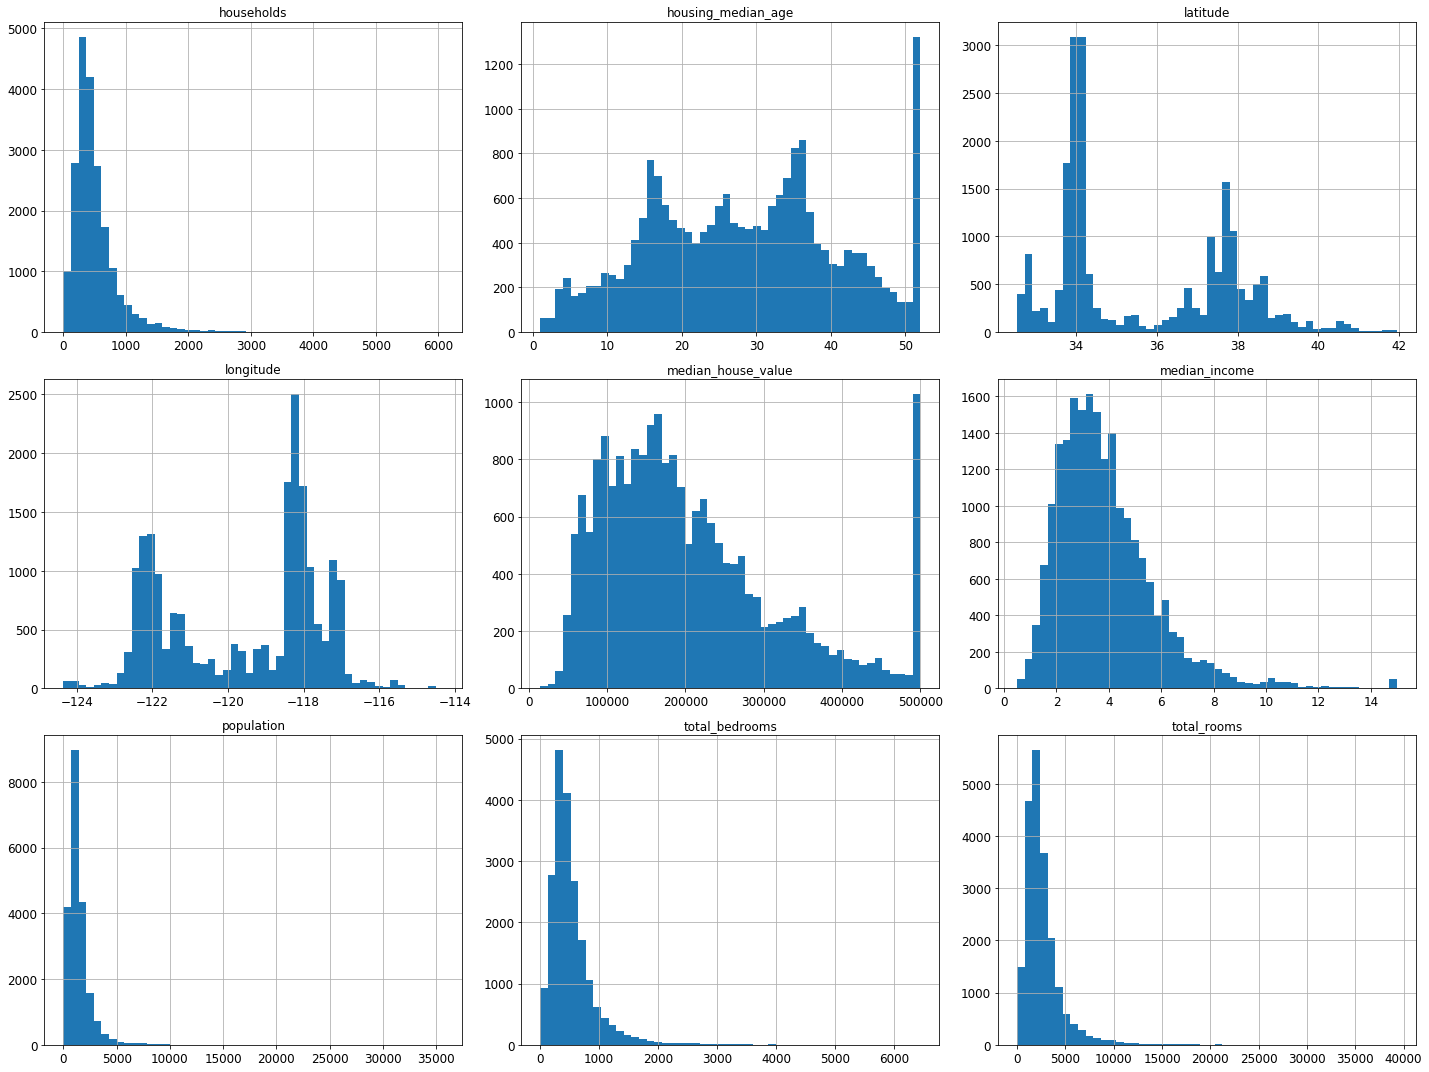

In [555]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()    # calling show() is optional in Jupyter notebook

In these plots, for example, you can see that slightly over 800 districts have a median_house_value equal to about $100,000.

Notice a few things in these histograms:
1. First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about 30,000 USD). Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.

2. The housing median age and the median house value were also capped (see the large populations in the final bin for both histograms). The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise predictions even beyond 500,000 USD, then you have mainly two options:<br>
a.    Collect proper labels for the districts whose labels were capped.<br>
b.    Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond 500,000 USD).

3. These attributes have very different scales. We will discuss this later in this chapter when we explore feature scaling.

4. Finally, many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

### Create a Test Set

Before looking at the data any further, you need to create a test set, put it aside, and never look at it.

The brain is an amazing pattern detection system, which means that it is highly prone to overfitting: if you look at the test set, you may stumble upon some seemingly interesting pattern in the test data that leads you to select a particular kind of Machine Learning model.

When you estimate the generalization error using the test set, your estimate will be too optimistic and you will launch a system that will not perform as well as expected. This is called **data snooping bias**.

Creating a test set is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large), and set them aside:

In [556]:
# Setting the random number generator's seed (np.random.seed(42)) before calling np.random.permutation() make this notebook's output identical at every run by always generating the same shuffled indices
np.random.seed(42)    # 42 - The Answer to the Ultimate Question of Life, the Universe, and Everything

In [557]:
# This bit is for illustration only. Sklearn has train_test_split() which we will use later
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [558]:
train_set, test_set = split_train_test(housing, 0.2)

In [559]:
len(train_set)

16512

In [560]:
len(test_set)

4128

As you can see above, we set the random number generator’s seed (e.g., np.random.seed(42)) before calling np.random.permutation(), so that it always generates the same shuffled indices.len(test_set). Another solution is to save the test set on the first run and then load it in subsequent runs.

But both these solutions will break next time you fetch an updated dataset. A common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). For example, you could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

Here is a possible implementation:

In [561]:
from zlib import crc32

In [562]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [563]:
import hashlib

In [564]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

Unfortunately, the housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID:

In [565]:
housing_with_id = housing.reset_index()    # adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset, and no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier.

For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID e.g.

In [566]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [567]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


The location information is actually quite coarse, and as a result many districts will have the exact same ID, so they will end up in the same set (test or train). This introduces some unfortunate sampling bias.

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), which does pretty much the same thing as the function split_train_test defined earlier, with a couple of additional features. First there is a random_state parameter that allows you to set the random generator seed as explained previously, and second you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices (this is very useful, for example, if you have a separate DataFrame for labels) e.g.

In [568]:
from sklearn.model_selection import train_test_split

In [569]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [570]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant **sampling bias**, a sample that is not a true representation of the whole population.

When a survey company decides to call 1,000 people to ask them a few questions, they don’t just pick 1,000 people randomly in a phone book. They try to ensure that these 1,000 people are representative of the whole population. For example, the US population is composed of 51.3% female and 48.7% male, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. This is called **stratified
sampling**: the population is divided into homogeneous subgroups called **strata**, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population. If they used purely random sampling, there would be about 12% chance of sampling a skewed test set with either less than 49% female or more than 54% female. Either way, the survey results would be significantly biased.

Suppose you chatted with experts who told you that the median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute. Let’s look at the median income histogram more closely e.g.

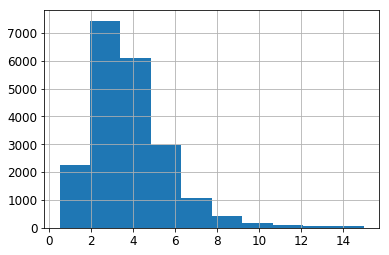

In [571]:
housing["median_income"].hist()

As you can see from the figure, most median income values are clustered around 1.5 to 6 (i.e., 15,000–60,000 USD), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The following code uses the [pd.cut()](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.cut.html) function to create an income category attribute with 5 categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, e.g.

In [572]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])

In [573]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

These income categories are represented as:

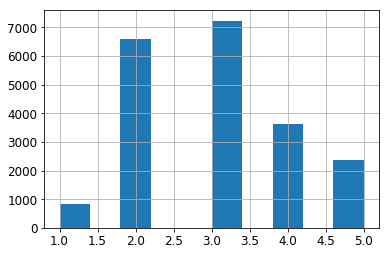

In [574]:
housing["income_cat"].hist()

Now we are ready to do stratified sampling based on the income category using Scikit-Learn’s [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) class e.g.

In [575]:
from sklearn.model_selection import StratifiedShuffleSplit

In [576]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

We can check this worked as expected by looking at the income category proportions in the test set e.g.

In [577]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [578]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

With similar code you can measure the income category proportions in the full dataset. The table code below generates a table that compares the income category proportions in the overall dataset, in the test set generated with stratified sampling, and in a test set generated using purely random sampling. As you can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is quite skewed.

In [579]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Random": income_cat_proportions(test_set),
    "Stratified": income_cat_proportions(strat_test_set)
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [580]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1,0.039826,0.040213,0.039729,0.973236,-0.243309
2,0.318847,0.324370,0.318798,1.732260,-0.015195
3,0.350581,0.358527,0.350533,2.266446,-0.013820
4,0.176308,0.167393,0.176357,-5.056334,0.027480
5,0.114438,0.109496,0.114583,-4.318374,0.127011


Finally, we remove the income_cat attribute so the data is back to its original state e.g.

In [581]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

A lot of time was spent on generating the test set a this is for a good reason: this is an often neglected but critical part of a Machine Learning project. Moreover, many of these ideas will be useful later when we discuss cross-validation. Now it’s time to move on to the next stage: exploring the data.

<a id='section3'></a>

## 3. Discover and Visualize the Data to Gain Insights

So far we have just taken a quick glance at the data to get a general understanding of the kind of data we are manipulating. Now we're going to go a little bit more in depth. 

The test set has been put aside and we are are only exploring the training set. If the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. However, in our case, the set is quite small (16,512 entries) so we can just work directly on the full set.

However, we'll create a copy so you can play with it without harming the training set:

In [582]:
housing = strat_train_set.copy()

### Visualizing Geographical Data

With geographical information (latitude and longitude), we can create a scatterplot of all districts to visualize the data e.g.

Saving figure bad_visualisation_plot


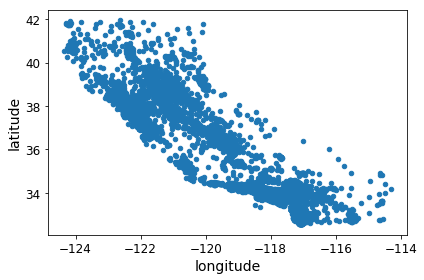

In [583]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualisation_plot")

In [584]:
from IPython.display import Image
from IPython.core.display import HTML

In [585]:
Image(url= "images/end_to_end_project/california-county-map.gif", width=250)

The scatter plot looks like the outline of California. Other than that however, it is hard to see any particular pattern.

We can set the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points e.g.

Saving figure better_visualization_plot


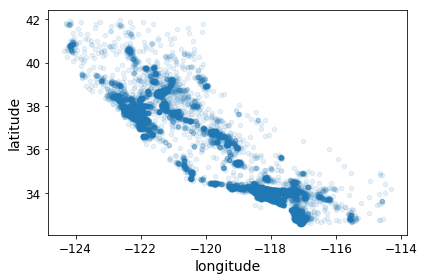

In [586]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

With alpha set to 0.1, can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno.

More generally, our brains are very good at spotting patterns on pictures, but you may need to play around with visualization parameters to make the patterns stand out.

In the next plot, the radius of each circle represents the district’s population (option s), and the color represents the price (option c). We have used  predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices) e.g.

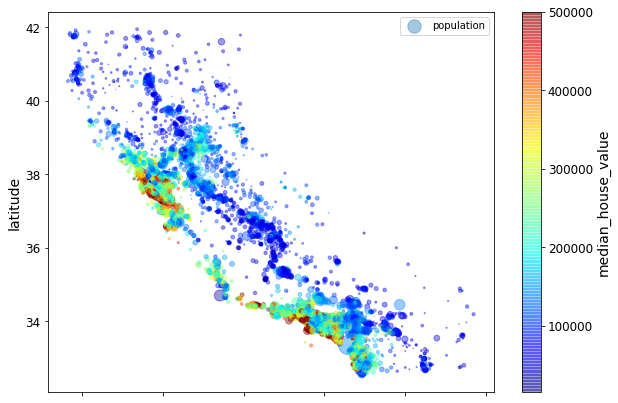

In [587]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10, 7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True
)
plt.legend()

This image shows us that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density, which was probably quite obvious before looking at the data. It will probably be useful to use a clustering algorithm to detect the main clusters, and add new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

In [588]:
import matplotlib.image as mpimg

Saving figure california_housing_prices_plot


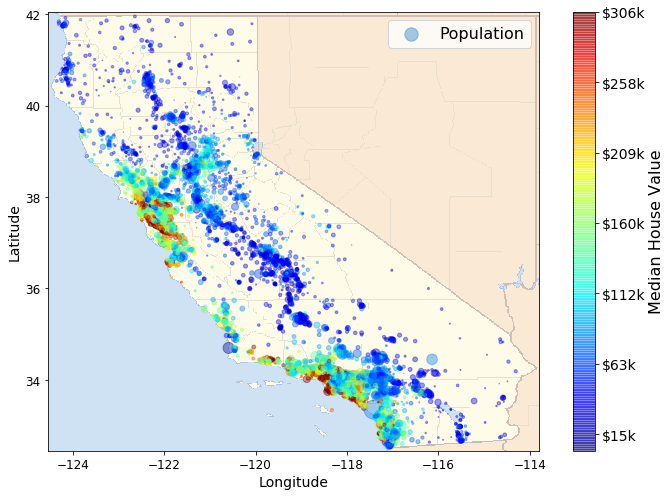

In [589]:
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

### Looking for Correlations

Since the dataset is not too large, we can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using the [corr()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) method e.g.

In [590]:
corr_matrix = housing.corr()

Now let’s look at how much each attribute correlates with the median house value e.g.

In [591]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The correlation coefficient ranges from –1 to 1. 

When the coefficient is close to 1, it means that there is a strong positive correlation i.e. the median house value tends to go up when the median income goes up. 

When the coefficient is close to –1, it means that there is a strong negative correlation i.e. you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north).

Finally, coefficients close to zero mean that there is no linear correlation.

The figure below shows the plots of standard correlation coefficient of various datasets, along with the correlation coefficient between their horizontal and vertical axes. Source: [Wikipedia page for Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient).

In [592]:
Image(url= "images/end_to_end_project/standard_correlation_coefficients_wiki.png", width=650)

Note: The correlation coefficient only measures linear correlations (“if x
goes up, then y generally goes up/down”). It may completely miss out on nonlinear relationships (e.g., “if x is close to zero then y generally goes up”). Note how all the plots in the bottom row of the figure have a correlation coefficient equal to zero despite the fact that their axes are clearly not independent: these are examples of nonlinear relationships. Also, the second row shows examples where the correlation coefficient is equal to 1 or –1; notice that this has nothing to do with the slope. For example, your height in inches has a correlation coefficient of 1 with your height in feet or in nanometers.

Another way to check for correlation between attributes is to use Pandas’
[scatter_matrix](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.scatter_matrix.html) function, which plots every numerical attribute against every other numerical attribute.

Our dataset has 11 numerical attributes, which would therefore produce 121 plots (11 squared), which would take up a lot of space in the notebook. For now, we'll just focus on a few promising attributes that seem most correlated with `median_house_value` - `median_income`, `total_rooms`, and `housing_median_age`.

In [593]:
# From pandas.tools.plotting import scatter_matrix 
from pandas.plotting import scatter_matrix

Saving figure scatter_matrix_plot


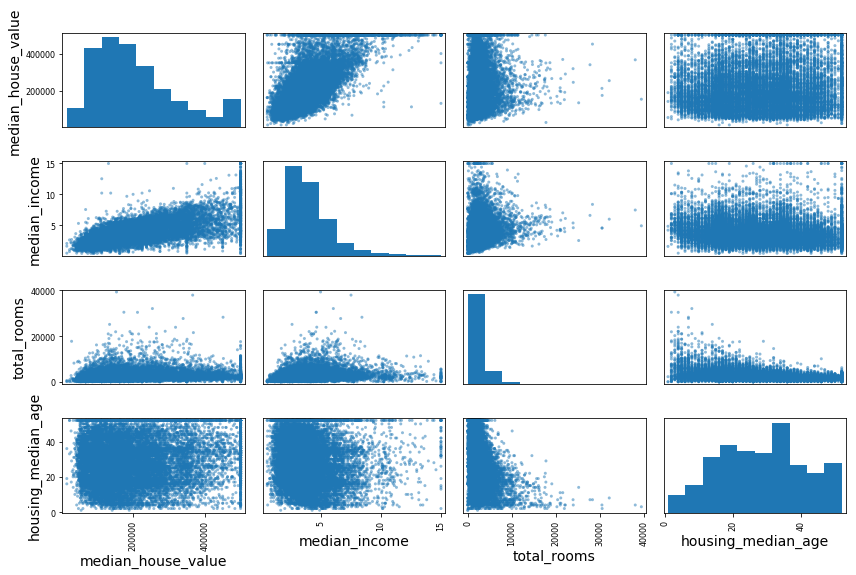

In [594]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

The main diagonal (top left to bottom right) would be full of straight lines if Pandas plotted each variable against itself, which would not be very useful. So instead Pandas displays a histogram of each attribute (other options are available; see Pandas’ documentation for more details).

The most promising attribute to predict the median house value is the median
income (1st row, 2 across), so let’s zoom in on their correlation scatterplot

Saving figure income_vs_house_value_scatterplot


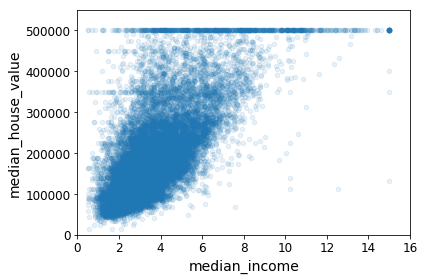

In [595]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

This plot reveals a few things.

Firstly, the correlation is indeed very strong; you can clearly see the upward trend and the points are not too dispersed.

Secondly, the price cap that we noticed earlier is clearly visible as a horizontal line at 500,000 USD. But this plot reveals other less obvious straight lines: a horizontal line around 450,000 USD, another around 350,000 USD, perhaps one around 280,000 USD, and a few more below that. It may be worth considering removing the corresponding districts to prevent our algorithms from learning to reproduce these data quirks.

So to summarise this section, we have shown a few ways you can explore the
data and gain insights. We identified a few data quirks that we may want to consider cleaning up before feeding the data to a Machine Learning algorithm. We also found interesting correlations between attributes, in particular with the target attribute - `median_house_value`. We also noticed that some attributes have a tail-heavy distribution, so we may want to transform them (e.g., by computing their logarithm). 

Depending on projects, the mileage of this analysis may vary considerably, but the general ideas are similar.

### Experimenting with Attribute Combinations

The last thing to do before actually preparing the data for Machine Learning algorithms is to try out various attribute combinations. For example, the
total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at.

Let’s create these new attributes:

In [596]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

And we look at the correlation matrix again:

In [597]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Not bad! The new `bedrooms_per_room attribute` is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. 

The number of `rooms_per_household` is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are (plotted as a scatterplot below).

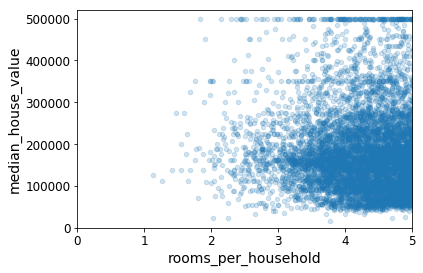

In [598]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value", alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

This round of exploration is not absolutely thorough; the point is to start off on the right foot and quickly gain insights that help to get to a first reasonably good prototype. But this is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.

In [599]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


<a id='section4'></a>

## 4. Prepare the Data for Machine Learning Algorithms

The next step is to prepare the data for Machine Learning algorithms. Instead of just doing this manually, we'll be writing functions to do that, for several good reasons:
*   This will allow us to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset).
*   We will gradually build a library of transformation functions that we can reuse in future projects.
*   We can use these functions in the live system to transform the new data before feeding it to the algorithms.
*   It will make it possible to easily try various transformations and see which combination of transformations works best.

First we'll revert to a clean training set (by copying strat_train_set once again), and separating the predictors and the labels as we don’t necessarily want to apply the same transformations to the predictors and the target values (note that drop() creates a copy of the data and does not affect strat_train_set) e.g.

In [600]:
housing = strat_train_set.drop("median_house_value", axis=1)    # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

Most Machine Learning algorithms cannot work with missing features, so we'll first create a few functions to take care of them. You noticed earlier that the `total_bedrooms` attribute has some missing values (207 out of 20,640).

There are three options to fix this:
*    Get rid of the corresponding districts.
*    Get rid of the whole attribute.
*    Set the values to some value (zero, the mean, the median, etc.).

This can be acomplished easily using Pandas’s [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html), [drop()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html), and [fillna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) methods.

First we'll create a DataFrame of incomplete from a sample e.g.

In [601]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


##### Option 1 - dropna()

In [602]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


##### Option 2 - drop()

In [603]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)    # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


##### Option 3 - fillna()

In [604]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)    # option 3

In [605]:
median

433.0

When choosing option 3, you need to the median value on the training set, and use it to fill the missing values in the training set, but also don’t forget to save the median value that you have computed. This will be needed later to replace missing values in the test set when evaluated the system, and also once the system goes live to replace missing values in new data.

In [606]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


As you can see in our new sample_incomplete_rows DataFrame, all rows now have 433.0 as the value for the `total_rooms`, the calculated mean for our training set.

Scikit-learn provides a handy class to take care of missing values: **[SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)**. To use SimpleImputer, first you need to create a SimpleImputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute e.g.

In [607]:
from sklearn.impute import SimpleImputer

In [608]:
imputer = SimpleImputer(strategy="median")

Since the median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute ocean_proximity e.g.

In [609]:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

Now you can fit the imputer instance to the training data using the fit() method:

In [610]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

The imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable. Only the `total_bedrooms` attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes. We can call this to see the values in an array e.g.

In [611]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Let's check that this is the same as manually computing the median of each attribute e.g.

In [612]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now you can use this “trained” imputer to transform the training set by replacing missing values by the learned medians:

In [613]:
X = imputer.transform(housing_num)

The result is a plain NumPy array containing the transformed features. To put it back into a Pandas DataFrame, you do the following:

In [614]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)    # index parameter not in book

Lets now see these changes made by the imputer rows referenced in the sample data set.

In [615]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [616]:
imputer.strategy

'median'

In [617]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [618]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


### Handling Test and Categorical Attributes

Earlier we left out the categorical attribute ocean_proximity because it is a text attribute so we cannot compute its median:

In [619]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


Most Machine Learning algorithms prefer to work with numbers anyway, so let’s convert these categories from text to numbers. For this, we can use Scikit-learn’s **[OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** class:

In [620]:
from sklearn.preprocessing import OrdinalEncoder

In [621]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

The list of categories can be accessed using the categories_ instance variable. This is a list containing a 1D array of categories for each categorical attribute (in this case, a list containing a single array since there is just one categorical attribute):

In [622]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad”, “average”, “good”, “excellent”), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called **one-hot encoding**, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called *dummy* attributes. Scikit-learn provides a **[OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)** class to convert categorical values into one-hot vectors e.g.

In [623]:
from sklearn.preprocessing import OneHotEncoder

In [624]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a SciPy sparse matrix, instead of a NumPy dense array. This is very useful when you have categorical attributes with thousands of categories. After onehot encoding we get a matrix with thousands of columns, and the matrix is full of zeros except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the non‐zero elements. You can use it mostly like a normal 2D array. We can also convert it to a (dense) NumPy array, if needed, by calling the `toarray()` method:

In [625]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Once again, you can get the list of categories using the encoder’s categories_ instance variable e.g.

In [626]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

If a categorical attribute has a large number of possible categories (e.g., country code, profession, species, etc.), then one-hot encoding will result in a large number of input features. This may slow down training and degrade performance. If this happens, you may want to replace the categorical input with useful numerical features related to the categories: for example, you could replace the ocean_proximity feature with the distance to the ocean (similarly, a country code could be replaced with the country’s population and GDP per capita). Alternatively, you could replace each category with a learnable low dimensional vector called an embedding. Each category’s representation would be learned during training: this is an example of **representation learning**.

### Customer Transformers

Although Scikit-learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-learn relies on duck typing (not inheritance), all you need is to create a class and implement three methods: fit() (returning self), transform(), and fit_transform(). You can get the last one for free by simply adding [TransformerMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) as a base class. Also, if you add [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) as a base class (and avoid *args and **kargs in your constructor) you will get two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning. For example, here is a small transformer class that adds the combined attributes we discussed earlier e.g.

In [627]:
from sklearn.base import BaseEstimator, TransformerMixin

In [628]:
# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [629]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In this example the transformer has one hyperparameter, add_bedrooms_per_room, set to True by default (it is often helpful to provide sensible defaults). This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically
try out, making it much more likely that you will find a great combination (and saving you a lot of time).

### Feature Scaling

One of the most important transformations you need to apply to your data is **feature scaling**. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.

There are two common ways to get all attributes to have the same scale: **min-max scaling** and **standardization**. 

Min-max scaling (also known as *normalization*) is quite simple: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-learn provides a transformer called **[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)** for this. It has a feature_range hyperparameter that lets you change the range if you don’t want 0–1 for some reason. 

Standardization is quite different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called **[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)** for standardization.

As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set (and new data).

### Transformation Pipelines

As you can see, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the **[Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)** class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes:

In [630]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [631]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

The Pipeline constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a fit_transform() method). The names can be anything you like (as long as they are unique and don’t contain double underscores “__”): they will come in handy later for hyperparameter tuning.

When you call the pipeline’s fit() method, it calls fit_transform() sequentially on all transformers, passing the output of each call as the parameter to the next call, until it reaches the final estimator, for which it just calls the fit() method.

The pipeline exposes the same methods as the final estimator. In this example, the last estimator is a **StandardScaler**, which is a transformer, so the pipeline has a transform() method that applies all the transforms to the data in sequence (and of course also a fit_transform() method, which is the one we used).

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column. In version 0.20, Scikit-Learn introduced the **[ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)** for this purpose, and the good news is that it works great with Pandas DataFrames. Let’s use it to apply all the transformations to the housing data:

In [632]:
from sklearn.compose import ColumnTransformer

In [633]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [634]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [635]:
housing_prepared.shape

(16512, 16)

Here is how this works: first we import the ColumnTransformer class, next we get thelist of numerical column names and the list of categorical column names, and we construct a ColumnTransformer. The constructor requires a list of tuples, where each tuple contains a name, a transformer and a list of names (or indices) of columns that the transformer should be applied to. In this example, we specify that the numerical columns should be transformed using the num_pipeline that we defined earlier, and the categorical columns should be transformed using a OneHotEncoder. Finally, we apply this ColumnTransformer to the housing data: it applies each transformer to the appropriate columns and concatenates the outputs along the second axis (the
transformers must return the same number of rows).

Note that the OneHotEncoder returns a sparse matrix, while the num_pipeline returns a dense matrix. When there is such a mix of sparse and dense matrices, the ColumnTransformer estimates the density of the final matrix (i.e., the ratio of non-zero cells), and it returns a sparse matrix if the density is lower than a given threshold (by default, sparse_threshold=0.3). In this example, it returns a dense matrix. And that’s it! We have a preprocessing pipeline that takes the full housing data and applies
the appropriate transformations to each column.

Instead of a transformer, you can specify the string "drop" if you want the columns to be dropped. Or you can specify "pass through" if you want the columns to be left untouched. By default, the remaining columns (i.e., the ones that were not listed) will be dropped, but you can set the remainder hyperparameter to any transformer (or to "passthrough") if you want these columns to be handled differently.

If you are using Scikit-Learn 0.19 or earlier, you can use a third-party library such as sklearn-pandas, or roll out your own custom transformer to get the same functionality as the ColumnTransformer. Alternatively, you can use the **[FeatureUnion](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html)** class which can also apply different transformers and concatenate their outputs, but you cannot specify different columns for each transformer, they all apply to the whole data. It is possible to work around this limitation using a custom transformer for column selection (see the Jupyter notebook for an example).

For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:

In [636]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

In [637]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [638]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [639]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

The result is the same as with the `ColumnTransformer`:

In [640]:
np.allclose(housing_prepared, old_housing_prepared)

True

<a id='section5'></a>

## 5. Select a model and train it.

At this point we have framed the problem, got the data and explored it, sampled a training set and a test set, wrote transformation pipelines to clean up and prepare your data for Machine Learning algorithms automatically.

The next stage is to select and train a Machine Learning model.

### Training and Evaluation on the Training Set

After all the previous steps, things are now quite simple. 

First, Let’s train a Linear Regression model e.g.

In [641]:
from sklearn.linear_model import LinearRegression

In [642]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Done in only two lines of code. We now have a working Linear Regression model. Let’s try it out on a few instances from the training set e.g.

In [643]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [644]:
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [645]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


It works, although the predictions are not exactly accurate (e.g., the first prediction is off by close to 40%!). Let’s measure this regression model’s RMSE on the whole training set using Scikit-learn’s mean_squared_error function:

In [646]:
from sklearn.metrics import mean_squared_error

In [647]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

Okay, this is better than nothing but clearly not a great score: most districts’ median_housing_values range between 120,000 USD and 265,000 USD, so a typical prediction error of 68,628 USD is not very satisfying. This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough. As we saw in the previous chapter, the main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or
to reduce the constraints on the model. This model is not regularized, so this rules out the last option. You could try to add more features (e.g., the log of the population), but first let’s try a more complex model to see how it does.

Let’s train a DecisionTreeRegressor. This is a powerful model, capable of finding complex nonlinear relationships in the data. The code should look familiar by now:

In [648]:
from sklearn.tree import DecisionTreeRegressor

In [649]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Now that the model is trained, let’s evaluate it on the training set:

In [650]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Wait, what!? No error at all? Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly overfit the data. How can you be sure? As we saw earlier, you don’t want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for training, and part for model validation.

### Better Evaluation Using Cross-Validation

One way to evaluate the Decision Tree model would be to use the train_test_split function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set. It’s a bit of work, but nothing too difficult and it would work fairly well.

A great alternative is to use Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [651]:
from sklearn.model_selection import cross_val_score

In [652]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

Scikit-Learn’s cross-validation features expect a utility function
(greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the preceding code computes -scores before calculating the square root.

In [653]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [69327.01708558 65486.39211857 71358.25563341 69091.37509104
 70570.20267046 75529.94622521 69895.20650652 70660.14247357
 75843.74719231 68905.17669382]
Mean: 70666.74616904806
Standard deviation: 2928.322738055112


Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to perform worse than the Linear Regression model! Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a score of approximately 71,407, generally ±2,439. You would not have this information if you just used one validation set. But cross-validation comes at the cost of training the model several times, so it is not always possible.

Let’s compute the same scores for the Linear Regression model just to be sure:

In [654]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983493


That’s right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model. Let’s try one last model now: the RandomForestRegressor. Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called Ensemble Learning, and it is often a great way to push ML algorithms even further. We will skip most of the code since it is essentially the same as for the other models:

In [655]:
from sklearn.ensemble import RandomForestRegressor

In [658]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [659]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [663]:
from sklearn.model_selection import cross_val_score

In [664]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring = "neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


In [668]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

Wow, this is much better: Random Forests look very promising. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data. However, before you dive much deeper in Random Forests, you should try out many other models from various categories of Machine Learning algorithms (several Support Vector Machines with different kernels, possibly a neural network, etc.), without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising models.

In [669]:
from sklearn.svm import SVR

In [670]:
svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

<a id='section6'></a>

## 6. Fine-tune your model

Let’s assume that you now have a shortlist of promising models. You now need to fine-tune them. Let’s look at a few ways you can do that.

### Grid Search

One way to do that would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore many combinations.

Instead you should get Scikit-Learn’s GridSearchCV to search for you. All you need to do is tell it which hyperparameters you want it to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameter values, using cross-validation. For example, the following code searches for the best combination of hyperparameter values for the RandomForestRegressor:

In [525]:
from sklearn.model_selection import GridSearchCV

In [672]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

When you have no idea what value a hyperparameter should have, a simple approach is to try out consecutive powers of 10 (or a smaller number if you want a more fine-grained search, as shown in this example with the n_estimators hyperparameter).

This param_grid tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of n_estimators and max_features hyperparameter values specified in the first dict (don’t worry about what these hyperparameters mean for now; they will be explained in Chapter 7), then try all 2 × 3 = 6 combinations of hyperparameter values in the second dict, but this time with the bootstrap hyperparameter set to False instead of True (which is the default value for this hyperparameter).

All in all, the grid search will explore 12 + 6 = 18 combinations of RandomForestRegressor hyperparameter values, and it will train each model five times (since we are using five-fold cross validation). In other words, all in all, there will be 18 × 5 = 90 rounds of training! It may take quite a long time, but when it is done you can get the best combination of parameters like this:

In [673]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

Since 8 and 30 are the maximum values that were evaluated, you should probably try searching again with higher values, since the score may continue to improve.

You can also get the best estimator directly:

In [674]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

If GridSearchCV is initialized with refit=True (which is the default), then once it finds the best estimator using crossvalidation, it retrains it on the whole training set. This is usually a good idea since feeding it more data will likely improve its performance.

And of course the evaluation scores are also available:

In [676]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64026.268005762395 {'max_features': 2, 'n_estimators': 3}
56026.97721399238 {'max_features': 2, 'n_estimators': 10}
52712.48923745799 {'max_features': 2, 'n_estimators': 30}
60289.49027050891 {'max_features': 4, 'n_estimators': 3}
52682.285580278345 {'max_features': 4, 'n_estimators': 10}
50404.119544206405 {'max_features': 4, 'n_estimators': 30}
58449.20887839518 {'max_features': 6, 'n_estimators': 3}
52715.786870577904 {'max_features': 6, 'n_estimators': 10}
50268.34166993832 {'max_features': 6, 'n_estimators': 30}
59141.21894505952 {'max_features': 8, 'n_estimators': 3}
52108.54002331063 {'max_features': 8, 'n_estimators': 10}
50353.5699358222 {'max_features': 8, 'n_estimators': 30}
62100.0346303119 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54190.36926773346 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60127.35023376418 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53019.34892570695 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In this example, we obtain the best solution by setting the max_features hyperparameter to 8, and the n_estimators hyperparameter to 30. The RMSE score for this combination is 49,682, which is slightly better than the score you got earlier using the default hyperparameter values (which was 50,182). Congratulations, you have successfully fine-tuned your best model!

Don’t forget that you can treat some of the data preparation steps as hyperparameters. For example, the grid search will automatically find out whether or not to add a feature you were not sure about (e.g., using the add_bedrooms_per_room hyperparameter of your CombinedAttributesAdder transformer). It may similarly be used to automatically find the best way to handle outliers, missing features, feature selection, and more.

### Randomised Search

The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:
*    If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).
*    You have more control over the computing budget you want to allocate to hyperparameter search, simply by setting the number of iterations.

### Ensemble Methods

Another way to fine-tune your system is to try to combine the models that perform best. The group (or “ensemble”) will often perform better than the best individual model (just like Random Forests perform better than the individual Decision Trees they rely on), especially if the individual models make very different types of errors.

### Analyse the Best Models and Their Errors

You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions e.g.

In [677]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.03002166e-02, 7.54037814e-02, 3.93379238e-02, 1.73962496e-02,
       1.69520886e-02, 1.82845692e-02, 1.53538867e-02, 3.09623586e-01,
       6.51355625e-02, 1.06389962e-01, 7.85513762e-02, 1.18990026e-02,
       1.55104617e-01, 7.73508152e-05, 3.66245894e-03, 6.52736766e-03])

Let’s display these importance scores next to their corresponding attribute names:

In [679]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.30962358636588455, 'median_income'),
 (0.15510461740360404, 'INLAND'),
 (0.10638996166992191, 'pop_per_hhold'),
 (0.08030021662173066, 'longitude'),
 (0.07855137619922267, 'bedrooms_per_room'),
 (0.07540378138511077, 'latitude'),
 (0.06513556246374042, 'rooms_per_hhold'),
 (0.03933792375028191, 'housing_median_age'),
 (0.01828456919948135, 'population'),
 (0.017396249606421884, 'total_rooms'),
 (0.016952088586200502, 'total_bedrooms'),
 (0.015353886733871693, 'households'),
 (0.011899002601932725, '<1H OCEAN'),
 (0.006527367658314464, 'NEAR OCEAN'),
 (0.0036624589390733013, 'NEAR BAY'),
 (7.735081520716755e-05, 'ISLAND')]

With this information, you may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful, so you could try dropping the others).

You should also look at the specific errors that your system makes, then try to understand why it makes them and what could fix the problem (adding extra features or, on the contrary, getting rid of uninformative ones, cleaning up outliers, etc.).

### Evaluate Your System on the Test Set

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. There is nothing special about this process; just get the predictors and the labels from your test set, run your full_pipeline to transform the data (call transform(), not fit_transform(), you do not want to fit the test set!), and evaluate the final model on the test set:

In [681]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) # => evaluates to 47,730.2

In some cases, such a point estimate of the generalization error will not be quite enough to convince you to launch: what if it is just 0.1% better than the model currently in production? You might want to have an idea of how precise this estimate is. For this, you can compute a 95% confidence interval for the generalization error using scipy.stats.t.interval():

In [682]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45382.64678084, 49252.77478733])

The performance will usually be slightly worse than what you measured using crossvalidation if you did a lot of hyperparameter tuning (because your system ends up fine-tuned to perform well on the validation data, and will likely not perform as well on unknown datasets). It is not the case in this example, but when this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data. Now comes the project prelaunch phase: you need to present your solution (highlighting what you have learned, what worked and what did not, what assumptions were made, and what your system’s limitations are), document everything, and create nice presentations with clear visualizations and easy-to-remember statements (e.g., “the median income is the number one predictor of housing prices”). In this California housing example, the final performance of the system is not better than the experts’, but it may still be a good idea to launch it, especially if this frees up some time for the experts so they can work on more interesting and productive tasks.

<a id='section7'></a>

## 7. Present your solution

<a id='section8'></a>

## 8. Launch, monitor, and maintain your system

Perfect, you got approval to launch! You need to get your solution ready for production, in particular by plugging the production input data sources into your system and writing tests.

You also need to write monitoring code to check your system’s live performance at regular intervals and trigger alerts when it drops. This is important to catch not only sudden breakage, but also performance degradation. This is quite common because models tend to “rot” as data evolves over time, unless the models are regularly trained on fresh data.

Evaluating your system’s performance will require sampling the system’s predictions and evaluating them. This will generally require a human analysis. These analysts may be field experts, or workers on a crowdsourcing platform (such as Amazon Mechanical Turk or CrowdFlower). Either way, you need to plug the human evaluation pipeline into your system. You should also make sure you evaluate the system’s input data quality. Sometimes performance will degrade slightly because of a poor quality signal (e.g., a malfunctioning sensor sending random values, or another team’s output becoming stale), but it may take a while before your system’s performance degrades enough to trigger an alert. If you monitor your system’s inputs, you may catch this earlier. Monitoring the inputs is particularly important for online learning systems.

Finally, you will generally want to train your models on a regular basis using fresh data. You should automate this process as much as possible. If you don’t, you are very likely to refresh your model only every six months (at best), and your system’s performance may fluctuate severely over time. If your system is an online learning system, you should make sure you save snapshots of its state at regular intervals so you can easily roll back to a previously working state.

<a id='sectionsummary'></a>

## Summary

Hopefully this notebook provides a good idea of what a Machine Learning project looks like, and showed you some of the tools you can use to train a great system. As you can see, much of the work is in the data preparation step, building monitoring tools, setting up human evaluation pipelines, and automating regular model training. The Machine Learning algorithms are also important, of course, but it is probably preferable to be comfortable with the overall process and know three or four algorithms well rather than to spend all your time exploring advanced algorithms and not enough time on the overall process.

<a id='sectionbib'></a>

## Bibliography

* [Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://github.com/ageron/handson-ml2) - Aurélien Géron‘s GitHub repository. His copy of this workbook can be found [here](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb)
<br>

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. An accompanying blog post for this notebook can be found at my blog [here](https://www.eddwebster.com/blog/prediction-of-californian-house-prices/) for more projects. If you'd like to get in contact, my email is: edd.j.webster@gmail.com.***